# Caracterización Estadística y Cinemática: Señal del Bosón de Higgs ($H \to WW^*$) vs. Fondo Dibosón ($WW$)

## Objetivo
Evaluar la discriminabilidad entre la señal y el fondo mediante el análisis de las distribuciones cinemáticas y correlaciones entre variables. Este análisis busca validar la calidad de los datos simulados, identificar variables de alto poder predictivo (feature importance) y fundamentar la elección de la arquitectura de modelado.

#### Recordatorio teórico:
- **Señal**: Producción de bosón de Higgs decayendo a dos bosones W (uno off-shell)
- **Fondo**: Producción directa de pares WW (diboson)

In [3]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from src.data.merge_data import merge_and_save


plt.style.use("ggplot")

## 1. Carga de datos

In [6]:
merged_df = merge_and_save(
    "../data/raw/datos_filtrados_Higgs.csv",
    "../data/raw/datos_filtrados_DibosonWW.csv"
)

df = merged_df.copy()
df.head()

Cargando datos filtrados reales...
Todas las columnas físicas esperadas están presentes.
Todas las columnas físicas esperadas están presentes.
Higgs: 11340 eventos
DibosonWW: 14937 eventos
Dataset combinado guardado en: data/interim/merged_raw.pkl


,trigE,trigM,lep_n,jet_n,met_et,met_phi,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,...,jet_eta,jet_phi,jet_E,jet_MV2c10,sample,mLL,pTll,dphi_ll,dphi_ll_met,target
0,True,True,2,0,39938.445,1.856930,39422.570312,26516.251953,0.571867,-0.233551,...,0.000000,0.000000,0.000000,0.000000,WW,46.733593,53.660680,1.268602,3.098009,0
1,True,True,2,1,44835.996,-2.870015,55275.070312,29202.830078,0.167149,0.127004,...,0.525750,2.928067,72089.546875,-0.842718,WW,26.723835,80.155811,0.676783,2.675013,0
2,True,False,2,1,85033.480,0.415477,51790.308594,20564.869141,-0.560513,-0.214823,...,-0.278951,-1.938559,21311.076172,-0.690779,Higgs,12.353210,72.188777,0.150418,2.628970,1
3,False,True,2,1,80707.490,-2.295006,110044.054688,22830.406250,-0.192936,-0.658850,...,0.277890,-0.491223,93733.585938,-0.917005,WW,39.831298,128.935636,0.652169,1.997946,0
4,False,True,2,0,63765.820,0.468712,45380.273438,22644.166016,-0.425893,-0.911751,...,0.000000,0.000000,0.000000,0.000000,Higgs,24.319262,65.446771,0.587015,3.116981,1


In [7]:
# Información general 
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trigE            26277 non-null  bool   
 1   trigM            26277 non-null  bool   
 2   lep_n            26277 non-null  int64  
 3   jet_n            26277 non-null  int64  
 4   met_et           26277 non-null  float64
 5   met_phi          26277 non-null  float64
 6   lep_pt_0         26277 non-null  float64
 7   lep_pt_1         26277 non-null  float64
 8   lep_eta_0        26277 non-null  float64
 9   lep_eta_1        26277 non-null  float64
 10  lep_E_0          26277 non-null  float64
 11  lep_E_1          26277 non-null  float64
 12  lep_phi_0        26277 non-null  float64
 13  lep_phi_1        26277 non-null  float64
 14  lep_charge_0     26277 non-null  int64  
 15  lep_charge_1     26277 non-null  int64  
 16  lep_type_0       26277 non-null  int64  
 17  lep_type_1  

None

,lep_n,jet_n,met_et,met_phi,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_E_0,lep_E_1,...,jet_pt,jet_eta,jet_phi,jet_E,jet_MV2c10,mLL,pTll,dphi_ll,dphi_ll_met,target
count,26277.0,26277.000000,26277.000000,26277.000000,26277.000000,26277.000000,26277.000000,26277.000000,26277.000000,26277.000000,...,26277.000000,26277.000000,26277.000000,2.627700e+04,26277.000000,26277.000000,26277.000000,26277.000000,26277.000000,26277.000000
mean,2.0,0.477071,59110.404725,-0.034652,43427.843485,25963.975440,0.010250,0.010247,84706.840961,51128.471754,...,19861.233805,-0.000089,-0.008226,4.336685e+04,-0.342731,34.206549,62.874093,0.823600,2.766300,0.431556
std,0.0,0.499483,19907.629499,1.809936,15296.138643,7219.031971,1.212774,1.223119,59953.641120,34066.903296,...,27604.111007,0.929309,1.247137,7.311803e+04,0.404949,12.008011,19.470144,0.470946,0.371216,0.495303
min,2.0,0.000000,30000.895000,-3.141324,25004.300781,15000.686523,-2.497777,-2.498736,25078.302734,15051.084961,...,0.000000,-2.499286,-3.139826,0.000000e+00,-0.989868,10.004921,30.008225,0.000017,1.570825,0.000000
25%,2.0,0.000000,44920.492000,-1.591196,33468.066406,20929.242188,-0.956611,-0.967195,45625.968750,28525.181641,...,0.000000,0.000000,0.000000,0.000000e+00,-0.807873,24.490835,50.080951,0.431230,2.586673,0.000000
50%,2.0,0.000000,55546.355000,-0.044731,39563.574219,25144.857422,0.023947,0.012779,63850.117188,39284.230469,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,34.789580,58.929709,0.793910,2.892749,0.000000
75%,2.0,1.000000,68995.770000,1.521550,48682.132812,29636.914062,0.962374,0.988440,102706.296875,61451.109375,...,30484.619141,0.000000,0.000000,6.266488e+04,0.000000,44.154419,71.032740,1.196191,3.058904,1.000000
max,2.0,1.000000,272029.940000,3.141146,229780.562500,97331.070312,2.499152,2.499168,812129.250000,385418.875000,...,282940.906250,2.499703,3.141145,1.321130e+06,0.499919,54.999963,287.433644,1.799964,3.141593,1.000000


In [8]:
# Verificación valores faltantes 
df.isnull().sum().sort_values(ascending=False).head(20)

trigE             0
trigM             0
lep_n             0
jet_n             0
met_et            0
met_phi           0
lep_pt_0          0
lep_pt_1          0
lep_eta_0         0
lep_eta_1         0
lep_E_0           0
lep_E_1           0
lep_phi_0         0
lep_phi_1         0
lep_charge_0      0
lep_charge_1      0
lep_type_0        0
lep_type_1        0
lep_ptcone30_0    0
lep_ptcone30_1    0
dtype: int64

## 2. Exploración inicial del dataset

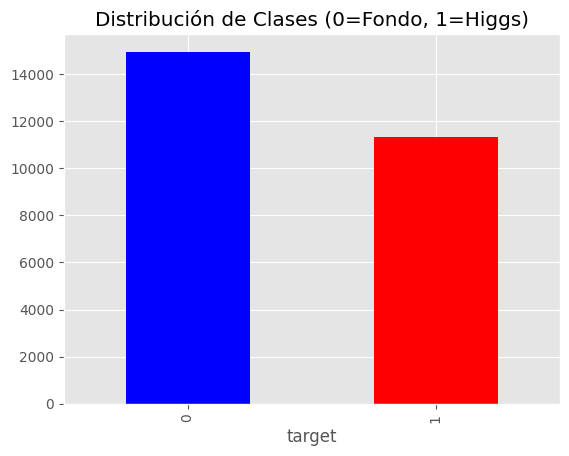

In [13]:
# Balance de clases
df['target'].value_counts().plot(kind='bar', color=['blue','red'])
plt.title("Distribución de Clases (0=Fondo, 1=Higgs)")
plt.show()


**Observación**: Dataset desbalanceado con ~43% señal Higgs y ~57% fondo WW. 

**Implicación**: Necesario usar **StratifiedKFold** para mantener proporciones en train/validation y evitar sesgo en el entrenamiento.

## 3. Distribuciones de Variables Físicas Clave

Análisis de separación entre señal y fondo para las variables cinemáticas.

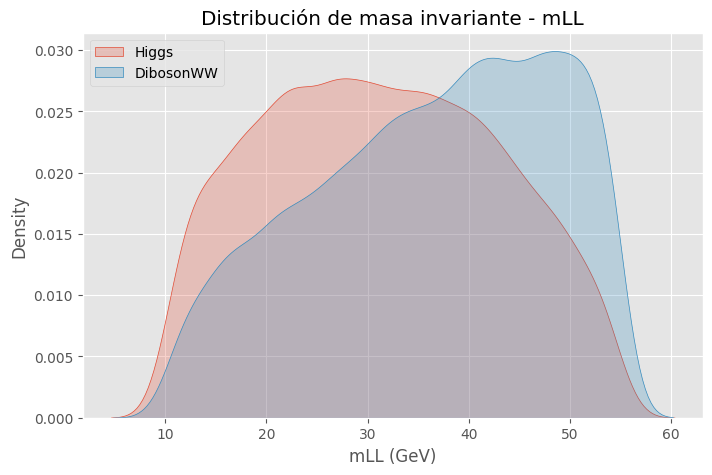

In [14]:
# Masa invariante del sistema dileptónico - mLL
plt.figure(figsize=(8,5))
sns.kdeplot(df[df.target==1]['mLL'], label='Higgs', fill=True)
sns.kdeplot(df[df.target==0]['mLL'], label='DibosonWW', fill=True)
plt.title("Distribución de masa invariante - mLL")
plt.xlabel("mLL (GeV)")
plt.legend()
plt.show()


**Interpretación física**:
- Higgs (H→WW*) presenta mLL bajo debido al W* off-shell (fuera de masa resonante)
- DibosonWW tiene distribución más extendida (ambos W on-shell)
- **Conclusión**: Variable altamente discriminante, crucial para el modelo

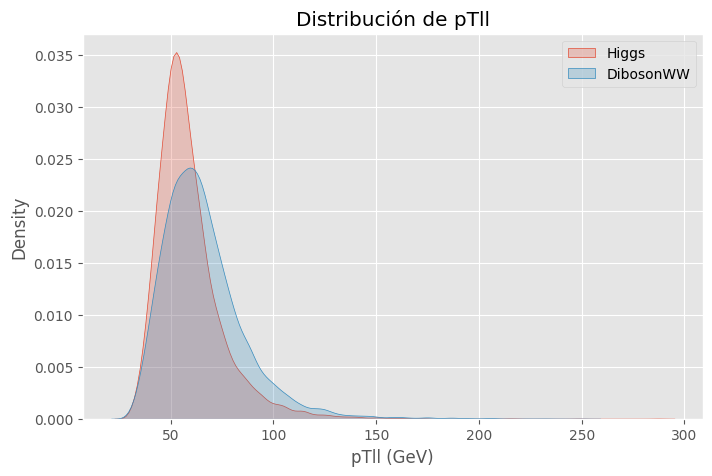

In [37]:
# Impulso transverse del sistema dileptónico - pTLL
plt.figure(figsize=(8,5))
sns.kdeplot(df[df.target==1]['pTll'], label='Higgs', fill=True)
sns.kdeplot(df[df.target==0]['pTll'], label='DibosonWW', fill=True)
plt.title("Distribución de pTll")
plt.xlabel("pTll (GeV)")
plt.legend()
plt.show()


**Interpretación física**:
- Higgs: pTll mayor debido a producción resonante del bosón de Higgs (boosted system)
- DibosonWW: distribución más suave por producción no-resonante
- **Conclusión**: Variable discriminante, captura cinemática del boost

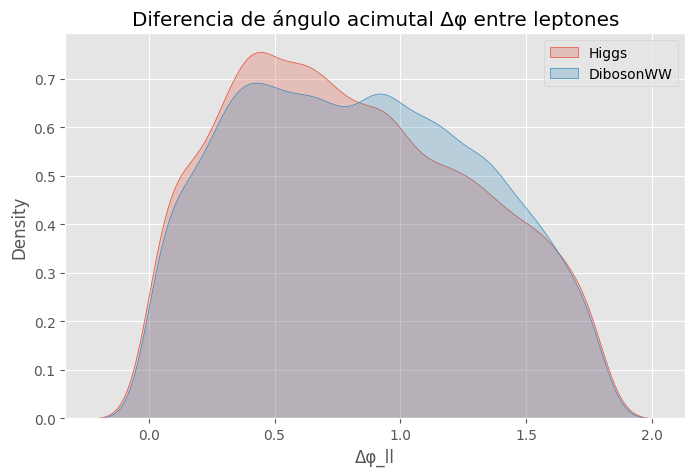

In [38]:
# Diferencia entre leptones - dPhiLL
plt.figure(figsize=(8,5))
sns.kdeplot(df[df.target==1]['dphi_ll'], label='Higgs', fill=True)
sns.kdeplot(df[df.target==0]['dphi_ll'], label='DibosonWW', fill=True)
plt.title("Diferencia de ángulo acimutal Δφ entre leptones")
plt.xlabel("Δφ_ll")
plt.legend()
plt.show()

**Interpretación física**:
- Higgs: leptones más colineales (Δφ pequeño) debido a la topología del decay H→WW*
- DibosonWW: leptones más separados angularmente
- **Conclusión**: Variable topológica importante para discriminación

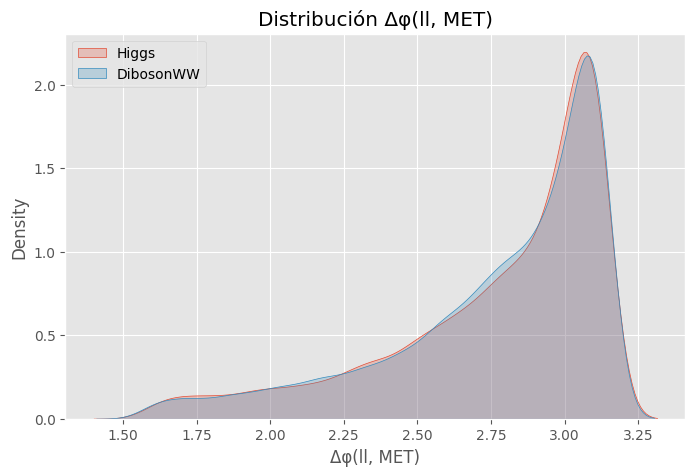

In [39]:
# Diferencia entre dileptón y MET - dPhiMETLL
plt.figure(figsize=(8,5))
sns.kdeplot(df[df.target==1]['dphi_ll_met'], label='Higgs', fill=True)
sns.kdeplot(df[df.target==0]['dphi_ll_met'], label='DibosonWW', fill=True)
plt.title("Distribución Δφ(ll, MET)")
plt.xlabel("Δφ(ll, MET)")
plt.legend()
plt.show()

**Interpretación física**:
Se observa que la variable $\Delta\phi(\ell\ell, E_T^{miss})$ presenta un bajo poder de separación individual (baja ganancia de información), dado que tanto la señal como el fondo exhiben una topología predominantemente 'back-to-back' ($\Delta\phi \approx \pi$)

### 3.5 Distribuciones Adicionales

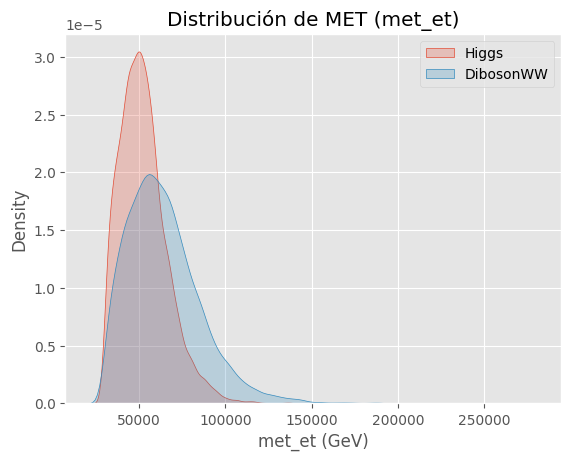

In [40]:
# Energía tranversal faltante - met_et
sns.kdeplot(df[df.target==1]['met_et'], label='Higgs', fill=True)
sns.kdeplot(df[df.target==0]['met_et'], label='DibosonWW', fill=True)
plt.title("Distribución de MET (met_et)")
plt.xlabel("met_et (GeV)")
plt.legend()
plt.show()


**Interpretación Física**: La variable met_et actúa como un discriminador robusto, permitiendo al modelo penalizar eventos con excesiva energía faltante que son característicos del fondo $WW$ y poco probables en la señal de Higgs.

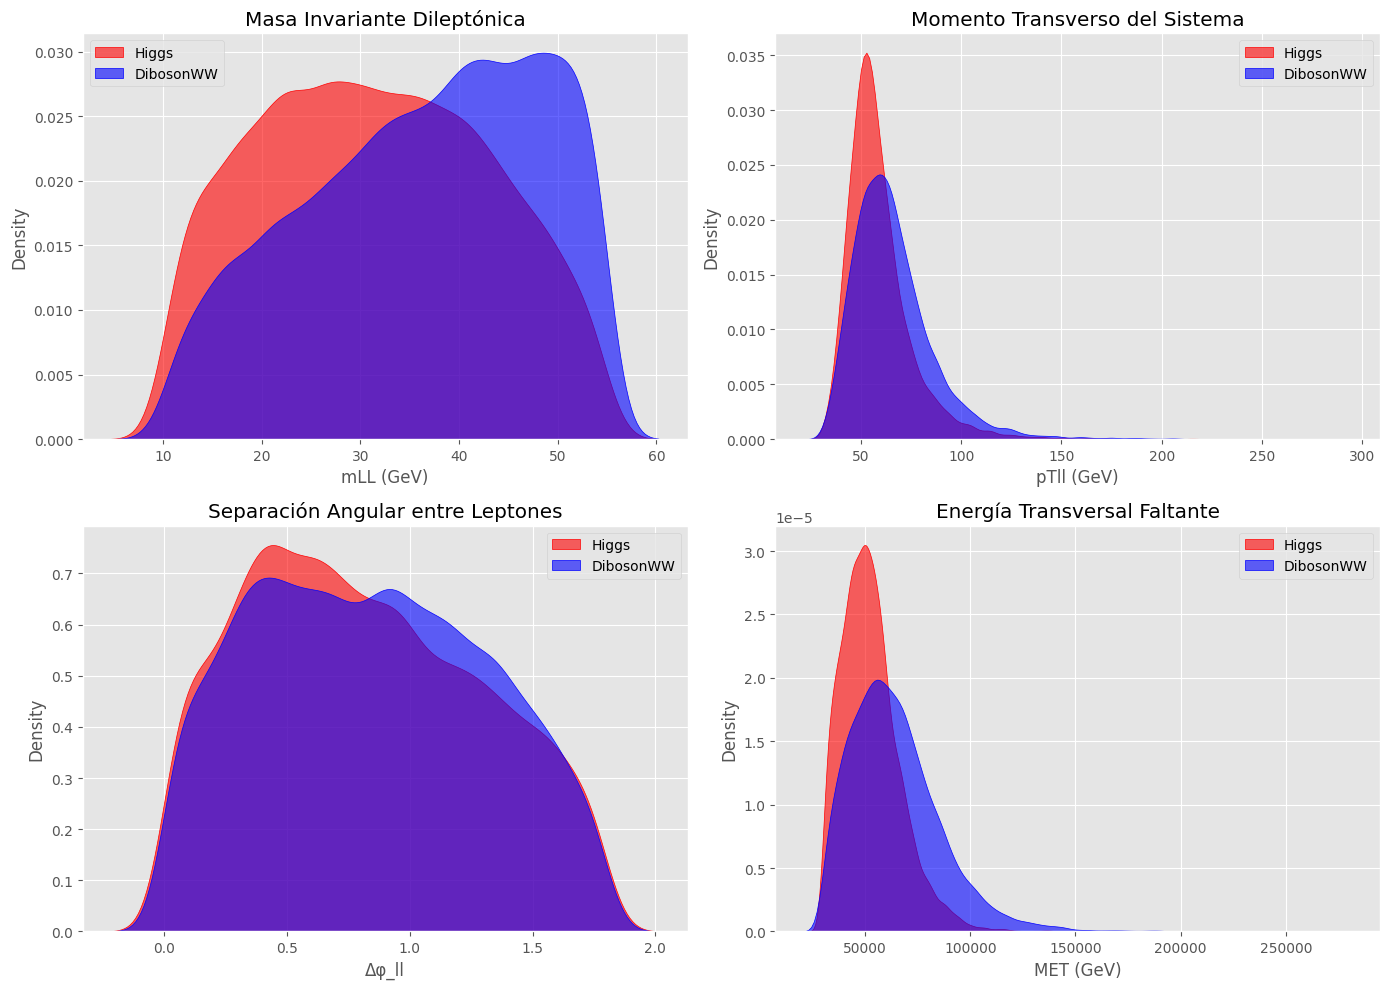

In [15]:
# Panel comparativo 
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# mLL
sns.kdeplot(df[df.target==1]['mLL'], label='Higgs', fill=True, ax=axes[0,0], color='red', alpha=0.6)
sns.kdeplot(df[df.target==0]['mLL'], label='DibosonWW', fill=True, ax=axes[0,0], color='blue', alpha=0.6)
axes[0,0].set_xlabel('mLL (GeV)')
axes[0,0].set_title('Masa Invariante Dileptónica')
axes[0,0].legend()

# pTll
sns.kdeplot(df[df.target==1]['pTll'], label='Higgs', fill=True, ax=axes[0,1], color='red', alpha=0.6)
sns.kdeplot(df[df.target==0]['pTll'], label='DibosonWW', fill=True, ax=axes[0,1], color='blue', alpha=0.6)
axes[0,1].set_xlabel('pTll (GeV)')
axes[0,1].set_title('Momento Transverso del Sistema')
axes[0,1].legend()

# dphi_ll
sns.kdeplot(df[df.target==1]['dphi_ll'], label='Higgs', fill=True, ax=axes[1,0], color='red', alpha=0.6)
sns.kdeplot(df[df.target==0]['dphi_ll'], label='DibosonWW', fill=True, ax=axes[1,0], color='blue', alpha=0.6)
axes[1,0].set_xlabel('Δφ_ll')
axes[1,0].set_title('Separación Angular entre Leptones')
axes[1,0].legend()

# met_et
sns.kdeplot(df[df.target==1]['met_et'], label='Higgs', fill=True, ax=axes[1,1], color='red', alpha=0.6)
sns.kdeplot(df[df.target==0]['met_et'], label='DibosonWW', fill=True, ax=axes[1,1], color='blue', alpha=0.6)
axes[1,1].set_xlabel('MET (GeV)')
axes[1,1].set_title('Energía Transversal Faltante')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Importancia de variables usando Random Forest

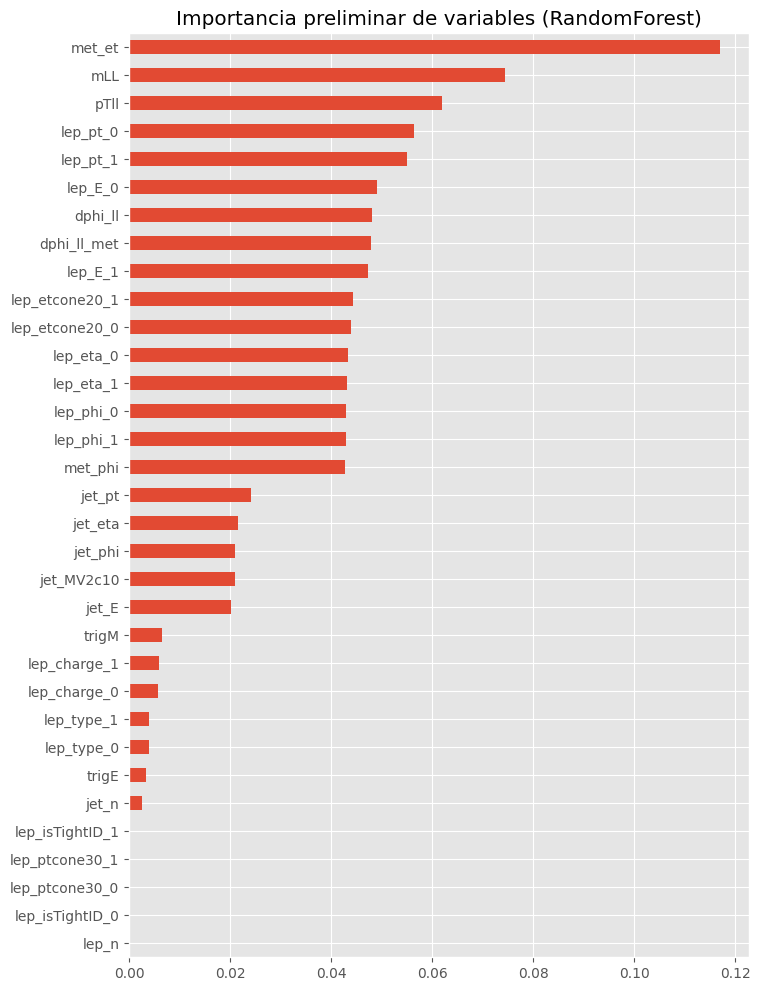

In [29]:
X = df.drop(columns=["target", "sample"])
y = df["target"]

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,12))
plt.title("Importancia preliminar de variables (RandomForest)")
plt.show()


El análisis de importancia de variables revela que el modelo basa sus decisiones principalmente en la Energía Faltante (met_et), identificándola como la característica con mayor poder predictivo para separar las clases (alta ganancia de información). Le sigue en relevancia la Masa Combinada (mLL), la cual funciona como una variable sintética muy eficiente

# Conclusiones 

**Balance de datos**:
- Dataset con 43% señal (Higgs) y 57% fondo (WW)
- Desbalance moderado por tanto se requiere **StratifiedKFold** para validación

**Calidad de datos**:
- Sin valores faltantes
- Sin inconsistencias estructurales
- Todas las variables físicas esperadas presentes
Es importante resaltar que este analisis es posterior al preprocesamiento de los datos crudos. 

**Variables discriminantes**:
1. **mLL** (masa invariante): máxima separación señal/fondo
2. **pTll** (momento transverso): captura boost del sistema
3. **dphi_ll** (separación angular): topología del decay
4. **dphi_ll_met** (balance energético): conservación de momento
5. **met_et** (Energía Faltante): Dureza dell espectro de energía

# Justificación del Modelo: Boosting (XGBoost/LightGBM)
1. Captura interacciones no-lineales entre variables físicas: 

La separación entre Higgs y el fondo WW no es linealmente separable en variables simples. Los árboles de decisión capturan naturalmente estos cortes rectangulares en el espacio n-dimensional.

2. Robusto a outliers en distribuciones de alta energía:

A diferencia de las Redes Neuronales o SVM, los modelos basados en árboles no requieren una estandarización agresiva (Z-score) de variables con rangos dispares (ej. masa en GeV vs eta adimensional), preservando la interpretabilidad física.

4. Funciona bien con estructura física del problema: 

En física de partículas, ciertas variables (como jet_mass) pueden no estar definidas para eventos con 0 jets. XGBoost maneja internamente estos valores (sparsity-aware split finding) sin necesidad de imputación artificial.

5. Eficiencia en Datos Tabulares Medianos: 

Con ~26k eventos, el Deep Learning corre riesgo de overfitting (sobreajuste) sin una arquitectura compleja de regularización. Boosting es el estado del arte (SOTA) para este régimen de datos tabulares.